In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Data

The data sets are already standardized with the `data/clean01.py` and `data/clean02.py` scripts so
whichever operation we can do on one data set, we can do on the other.

Genshin Impact, being the wonderful game that it is, has decided that it is going to have three types
of banners players can pull from. Thus, I am going to analyze them separately because _I do be eager
like that_.


## Data Format

I am going to skip the format of the original data set because it is irrelevant to this notebook.

The rows of the data sets are as following:

- **Rarity**: how many stars the character/weapon is classified as
- **Date**: date of the pull
- **Time**: time of the pull
- **Banner**: type of banner, described as following:
  - _200_: Permanent banner, always available to players
  - _301_ and _400_: Limited character banner, changes every now and then
  - _302_: Limited weapon banner, changes every now and then
- **Type**: drop type, either character or weapon
  - This attribute might interfere with our model so it might be dropped later on


In [2]:
from datetime import date, timedelta


def simplify_dt(given_dt: str):
    given_date, given_time = given_dt.split(' ')
    yr, mo, da = map(int, given_date.split('-'))
    hr, mi, _ = map(int, given_time.split(':'))

    pull_time = hr + round(mi / 60)
    pull_date = date(yr, mo, da) + timedelta(pull_time // 24)

    return (pull_date, pull_time % 24)


data_set01 = pd.read_csv("data/data01.csv")
data_set02 = pd.read_csv("data/data02.csv")
full_df = pd.concat([
    data_set01,
    data_set02,
]).reset_index().drop(["Type", "index"], axis=1)
full_df["DateTime"] = full_df["DateTime"].apply(simplify_dt)
full_df.sort_values("DateTime")

print(full_df.shape)
full_df.sample(5)


(9672437, 3)


,Rarity,DateTime,Banner
8916438,3,"(2021-04-28, 16)",200
6819369,3,"(2021-09-23, 21)",200
8403111,4,"(2022-04-14, 21)",301
1848804,3,"(2021-12-09, 17)",301
1314109,3,"(2022-06-15, 3)",400


# Reusable Code for Analysis

These are just some constants and functions used for analyzing the data.


## Constants


In [3]:
RELEASE_DATE = date(2020, 9, 28)
LAST_DAY_DATA = date(2022, 7, 26)
DAYS_SINCE_RELEASE = (LAST_DAY_DATA - RELEASE_DATE).days + 1


## Functions used to transform the data


In [4]:
def transform_rarity(banner: pd.DataFrame, cond_series: pd.Series, dimension: tuple[int, int]):
    grouped_counts = banner[cond_series]\
        .groupby("DateTime")\
        .count()

    ret_matrix = np.zeros(dimension)
    for i, key in enumerate(grouped_counts.index):
        d, t = key
        ret_matrix[t, d] = grouped_counts.iloc[i]

    return ret_matrix


def transform_func(banner: pd.DataFrame, date_transformer: callable, dimension: tuple[int, int]):
    banner = banner.drop("Banner", axis=1)
    banner["DateTime"] = banner["DateTime"].map(date_transformer)

    total = transform_rarity(banner, banner.Rarity != 0, dimension)
    five_stars = transform_rarity(banner, banner.Rarity == 5, dimension)
    four_stars = transform_rarity(banner, banner.Rarity == 4, dimension)

    return [total, five_stars / (total + 1), four_stars / (total + 1)]


def first_doy(d): return date(d.year, 1, 1)


def dow_transformer(dt): return (dt[0].weekday(), dt[1])
def dom_transformer(dt): return (dt[0].day - 1, dt[1])
def doy_transformer(dt): return ((first_doy(dt[0]) - dt[0]).days, dt[1])
def dsr_transformer(dt): return ((dt[0] - RELEASE_DATE).days, dt[1])


## Functions used to visualize the data


In [5]:
def dow_heatmap(data: np.ndarray, ax: plt.Axes, title: str):
    row_label = np.arange(0, 24)
    col_label = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

    d_min = np.min(data)
    d_max = np.max(data)
    sns.heatmap(data, yticklabels=row_label, xticklabels=col_label,
                vmin=d_min, vmax=d_max, ax=ax)
    ax.set_title(title)
    ax.set_ylabel("Hour of day")
    ax.set_xlabel("Day of week")


def dom_heatmap(data: np.ndarray, ax: plt.Axes, title: str):
    row_label = np.arange(0, 24)
    col_label = np.arange(1, 32)

    d_min = np.min(data)
    d_max = np.max(data)
    sns.heatmap(data, yticklabels=row_label, xticklabels=col_label, ax=ax,
                vmin=d_min, vmax=d_max)
    ax.set_title(title)
    ax.set_ylabel("Hour of day")
    ax.set_xlabel("Day of month")


def doy_heatmap(data: np.ndarray, ax: plt.Axes):
    months = ["January", "February", "March", "April", "May", "June",
              "July", "August", "September", "October", "November", "December"]
    days_in_months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    split_data = np.hsplit(data, np.cumsum(days_in_months))
    row_label = np.arange(0, 24)

    d_min = np.min(data)
    d_max = np.max(data)

    rows, cols = ax.shape
    for i in range(rows):
        for j in range(cols):
            idx_1d = i * rows + j
            split_col = np.arange(1, days_in_months[idx_1d] + 1)
            sns.heatmap(split_data[idx_1d], yticklabels=row_label, xticklabels=split_col,
                        ax=ax[i, j], vmin=d_min, vmax=d_max)
            ax[i, j].set_title(months[idx_1d])
            ax[i, j].set_ylabel("Hour of day")
            ax[i, j].set_xlabel("Day of year")


def dsr_heatmap(data: np.ndarray, axes: plt.Axes, bar_label: str, interval_name="Month"):
    n = axes.size
    months = [f"{interval_name} {i + 1}" for i in range(n)]
    data = data[:, :n * (data.shape[1] // n - 1)]
    xticks = np.arange(0, data.shape[1])

    split_data = np.hsplit(data, n)
    split_col = np.hsplit(xticks, n)

    row_label = np.arange(0, 24)

    d_min = np.min(data)
    d_max = np.max(data)

    for i, ax in enumerate(axes):
        sns.heatmap(split_data[i], yticklabels=row_label,
                    xticklabels=split_col[i], ax=ax, vmin=d_min, vmax=d_max)
        ax.set_title(months[i])
        ax.set_ylabel("Hour of day")
        ax.set_xlabel("Days since release")


# First Try: _Raw Data_


## Day of the Week


In [6]:
total_dow = transform_func(full_df, dow_transformer, (24, 7))
all_total, all_fives, all_fours = total_dow


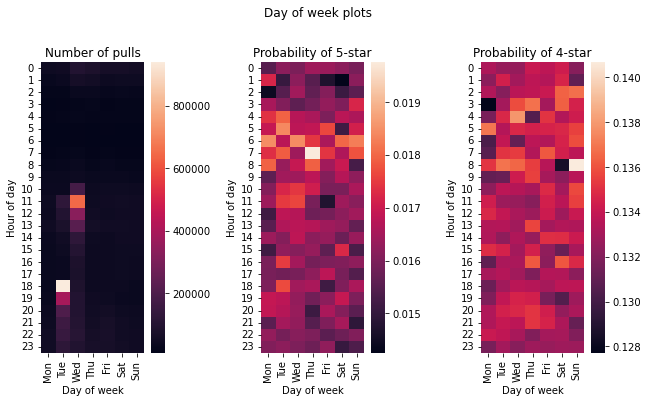

In [7]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(10, 6))
fig.tight_layout(pad=6.)
fig.suptitle("Day of week plots")

dow_heatmap(all_total, ax1, "Number of pulls")
dow_heatmap(all_fives, ax2, "Probability of 5-star")
dow_heatmap(all_fours, ax3, "Probability of 4-star")


## Day of Month


In [8]:
total_dom = transform_func(full_df, dom_transformer, (24, 31))
all_dom, all_fives, all_fours = total_dom


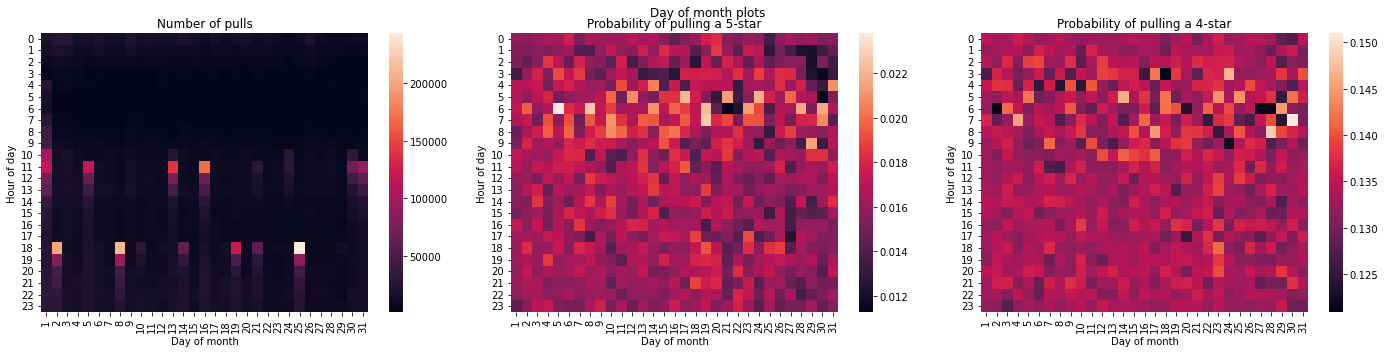

In [9]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(20, 5))
fig.tight_layout(pad=3.)
fig.suptitle("Day of month plots")

dom_heatmap(all_dom, ax1, "Number of pulls")
dom_heatmap(all_fives, ax2, "Probability of pulling a 5-star")
dom_heatmap(all_fours, ax3, "Probability of pulling a 4-star")


## Day of Year (by month)


In [10]:
YEAR_FIGSIZE = (26, 14)


In [11]:
total_doy = transform_func(full_df, doy_transformer, (24, 365))
all_total, all_fives, all_fours = total_doy


### Pulls


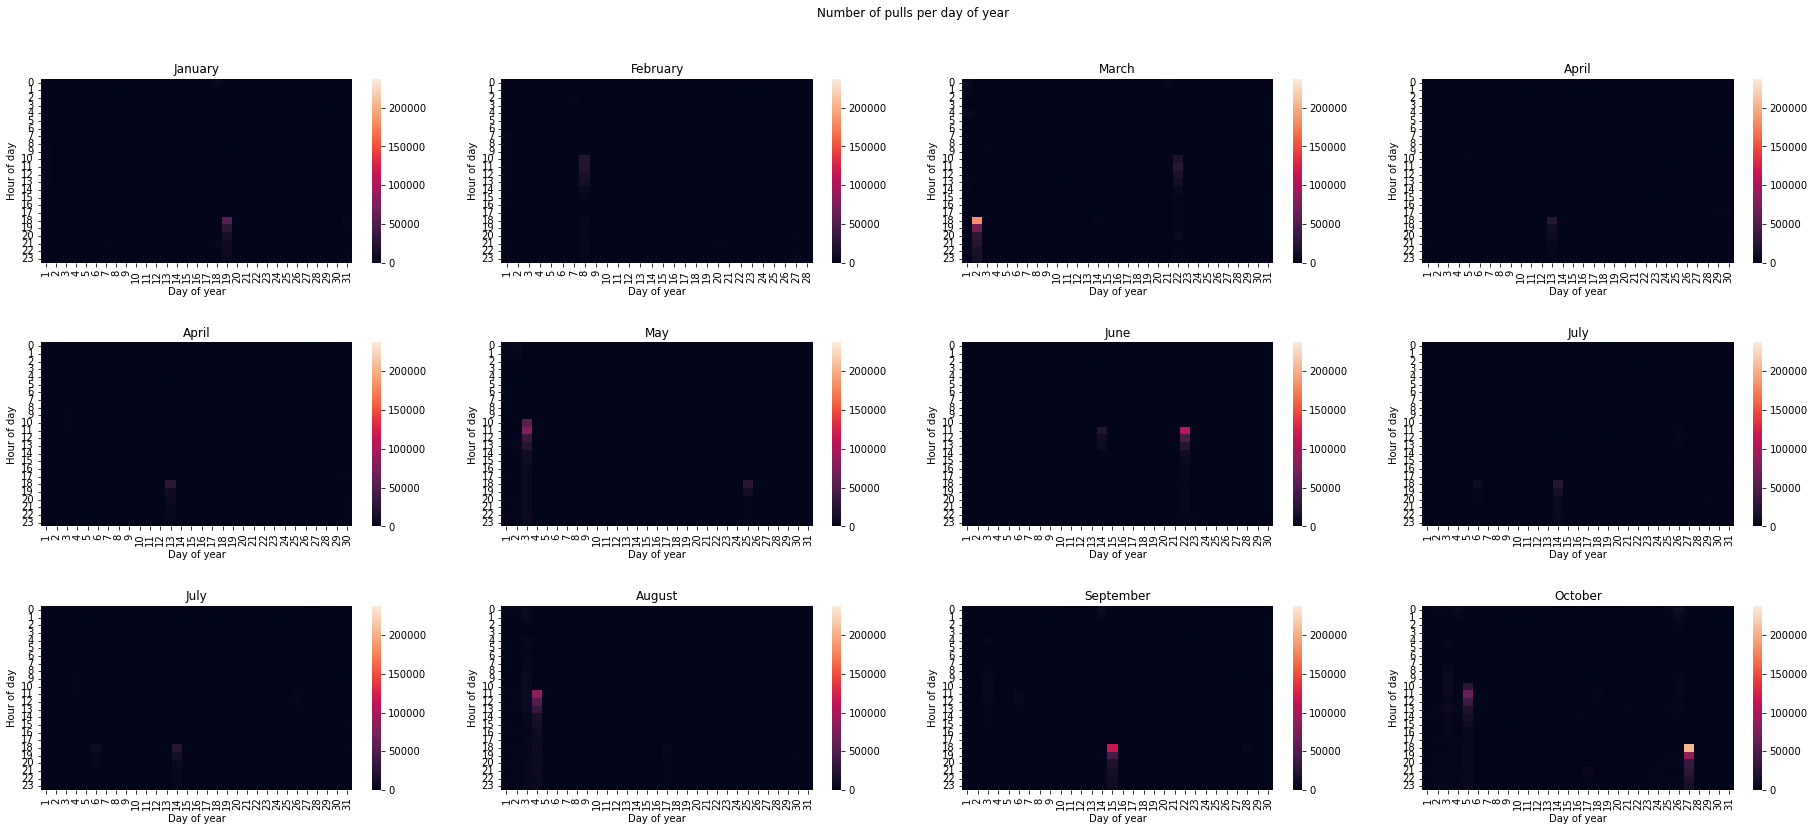

In [12]:
fig, ax = plt.subplots(3, 4, figsize=YEAR_FIGSIZE)
doy_heatmap(all_total, ax)
fig.suptitle("Number of pulls per day of year")
fig.tight_layout(pad=3.)

### 5-star


Text(0.5, 0.98, 'Probability of pulling a 5-star per day of year')

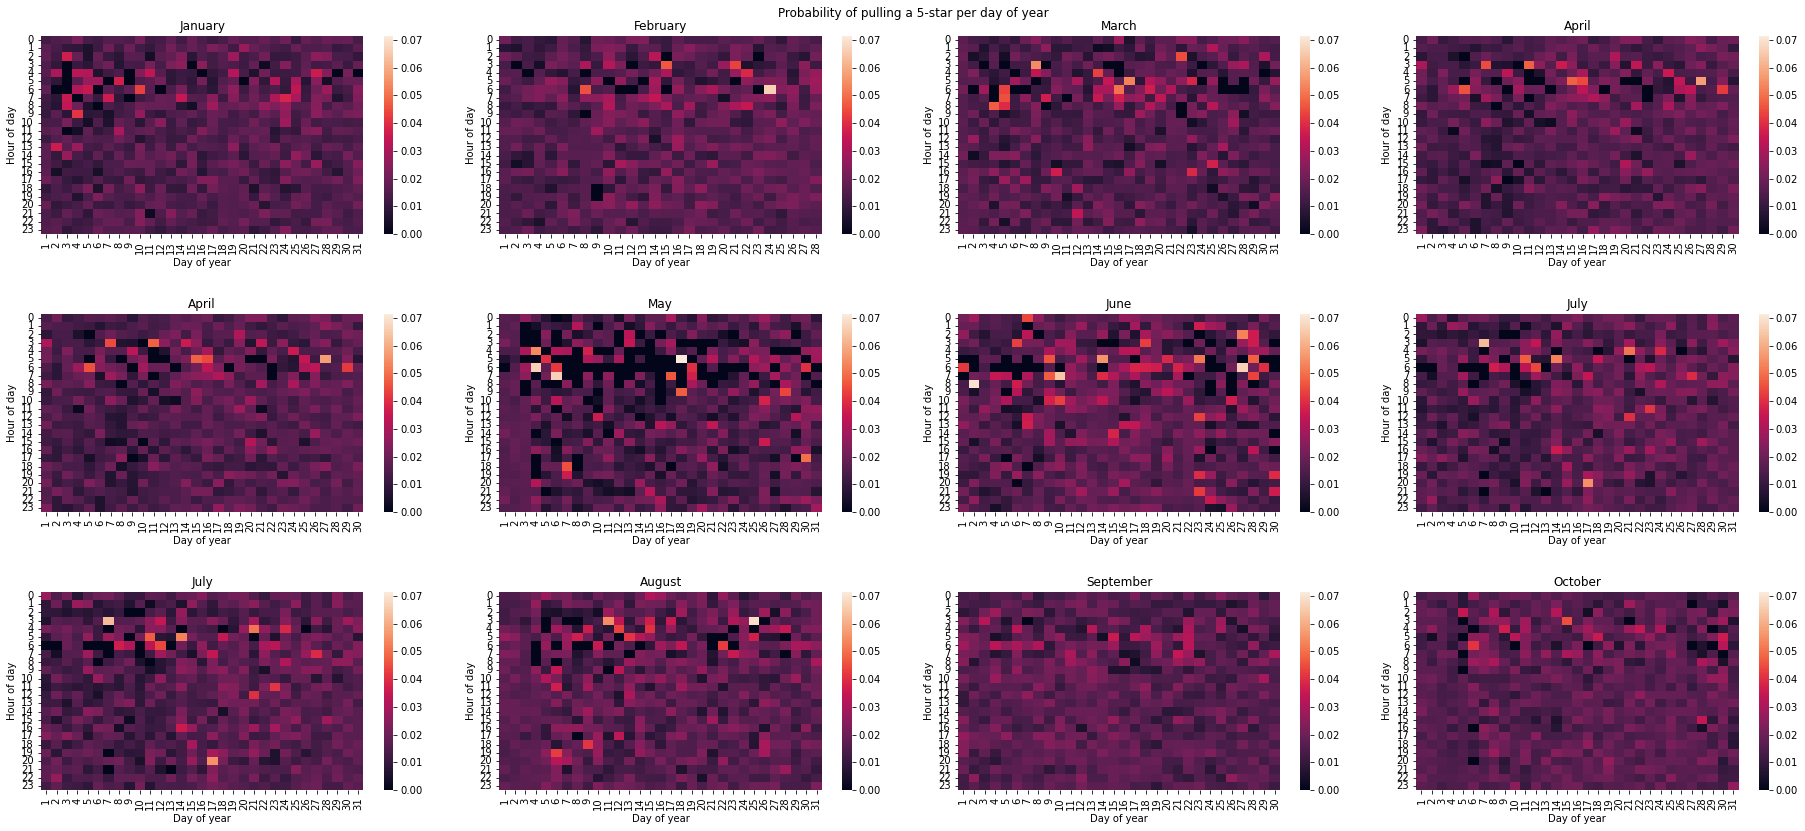

In [13]:
fig, ax = plt.subplots(3, 4, figsize=YEAR_FIGSIZE)
doy_heatmap(all_fives, ax)
fig.tight_layout(pad=3.)
fig.suptitle("Probability of pulling a 5-star per day of year")


### 4-star


Text(0.5, 0.98, 'Probability of pulling a 4-star per day of year')

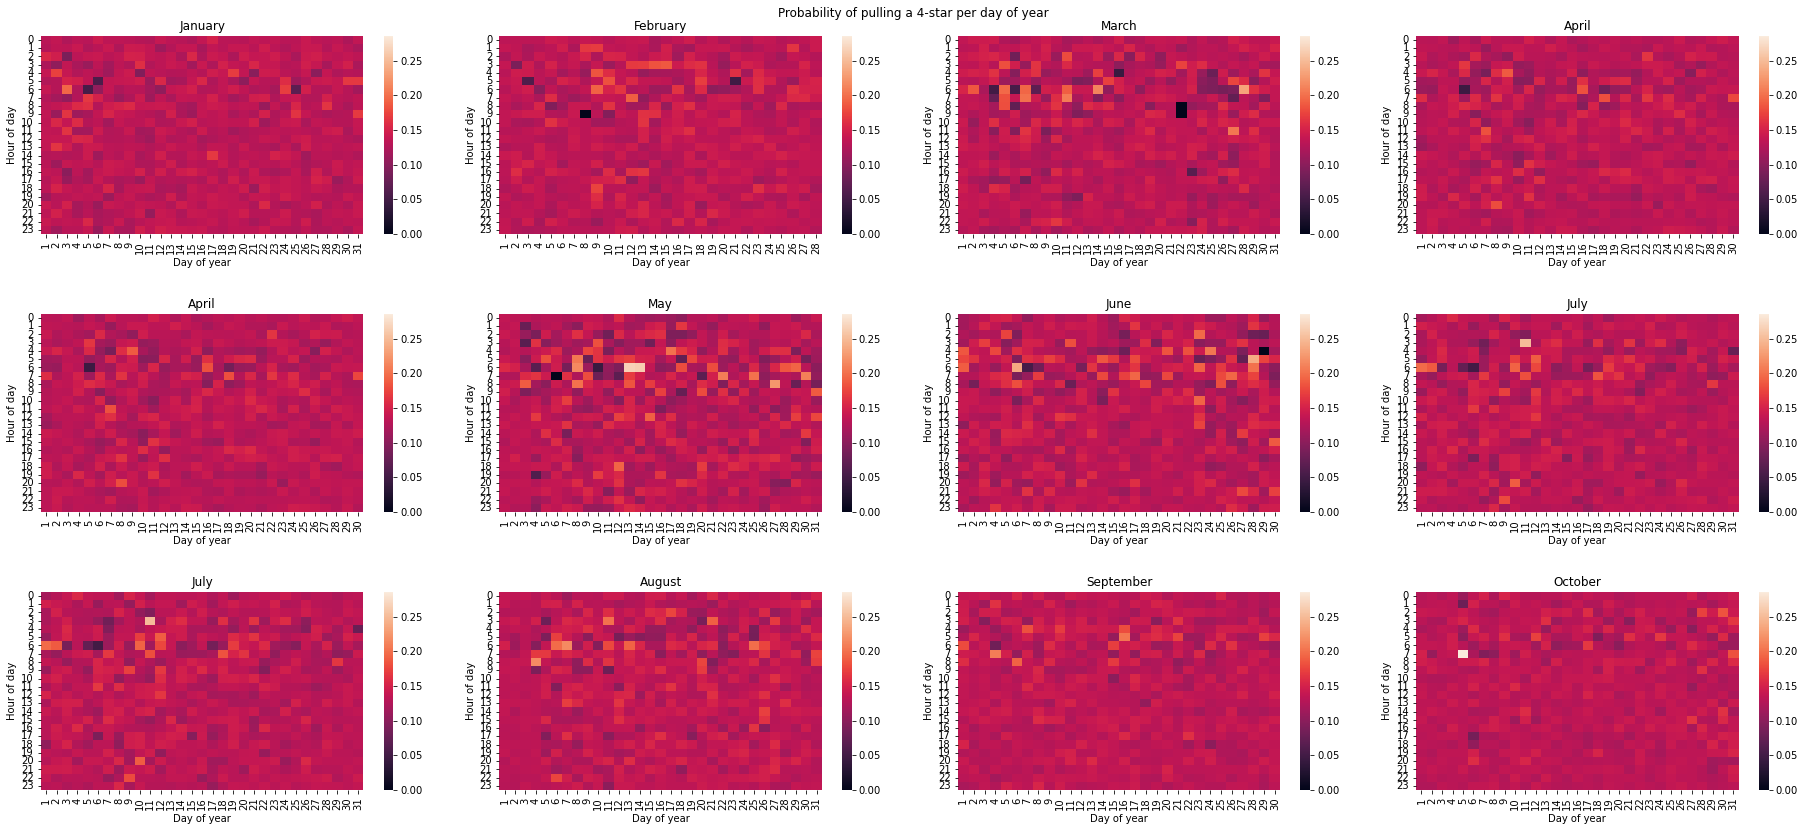

In [14]:
fig, ax = plt.subplots(3, 4, figsize=YEAR_FIGSIZE)
doy_heatmap(all_fours, ax)
fig.tight_layout(pad=3.)
fig.suptitle("Probability of pulling a 4-star per day of year")


## Days since release


In [45]:
DSR_ROWS = 4
DSR_PAD = 5.
DSR_FIGSIZE = (24, 16)

In [46]:
total_dsr = transform_func(full_df, dsr_transformer, (24, DAYS_SINCE_RELEASE))
all_total, all_fives, all_fours = total_dsr


### Pulls


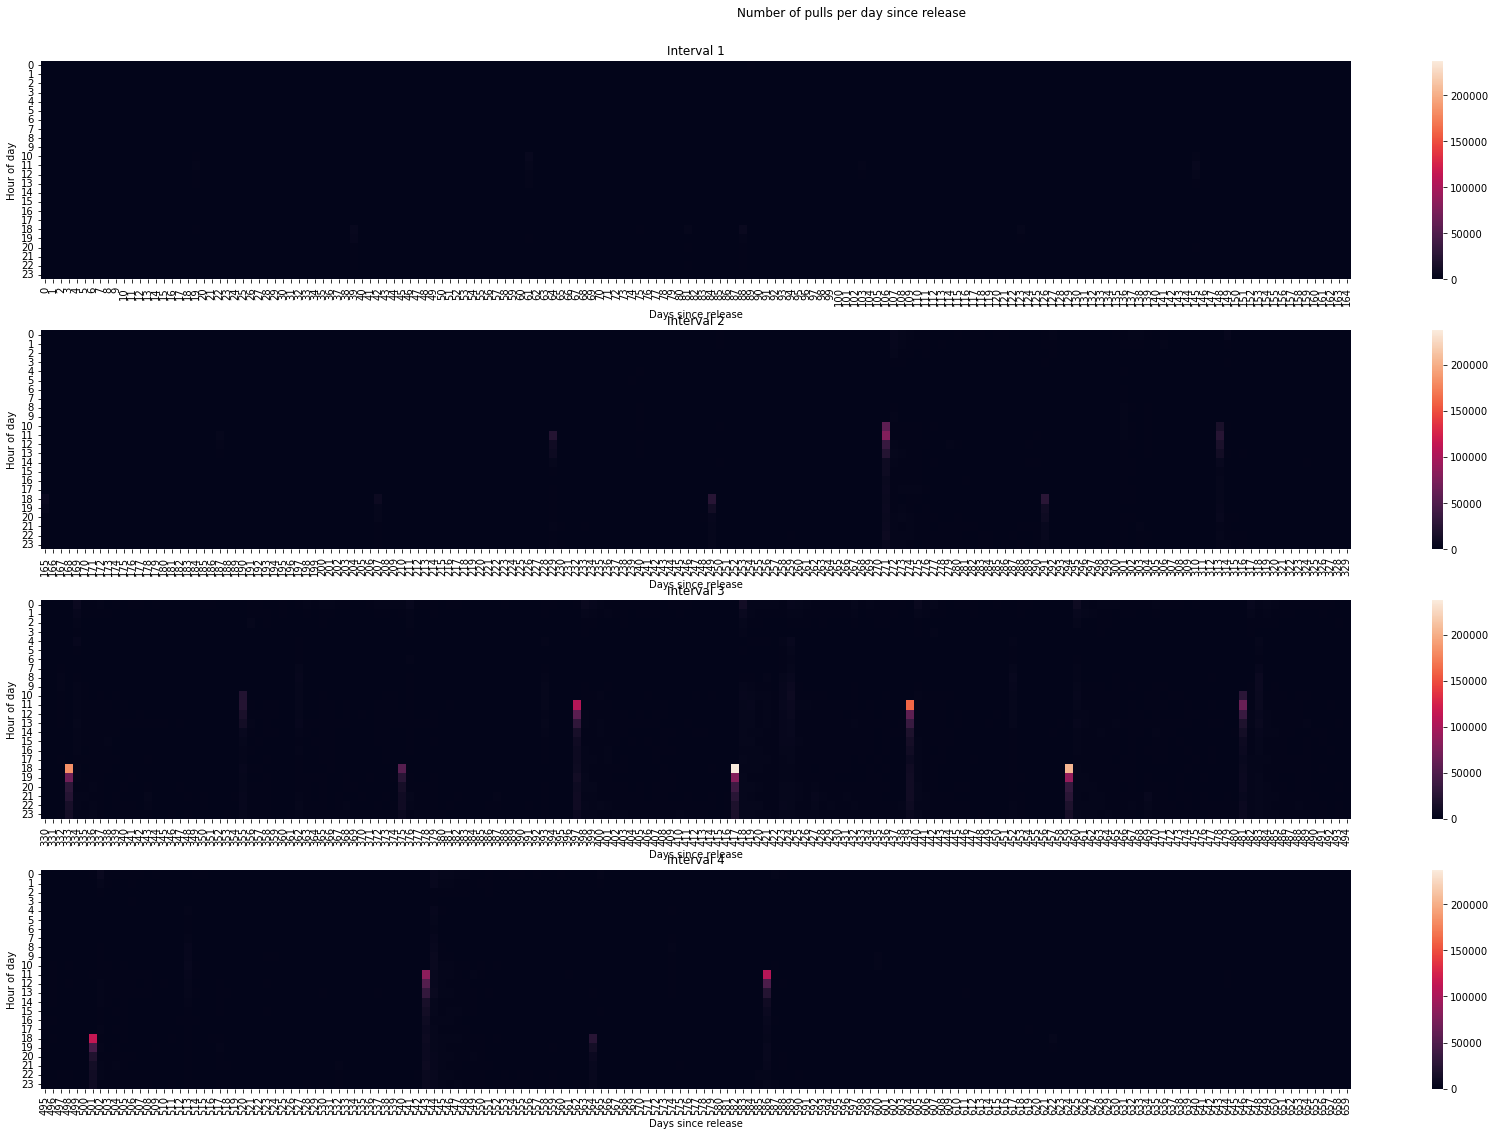

In [47]:
fig, ax = plt.subplots(DSR_ROWS, figsize=DSR_FIGSIZE)
fig.suptitle("Number of pulls per day since release")
fig.tight_layout(pad=DSR_PAD)
dsr_heatmap(all_total, ax, "Number of pulls", interval_name="Interval")

### 5-star


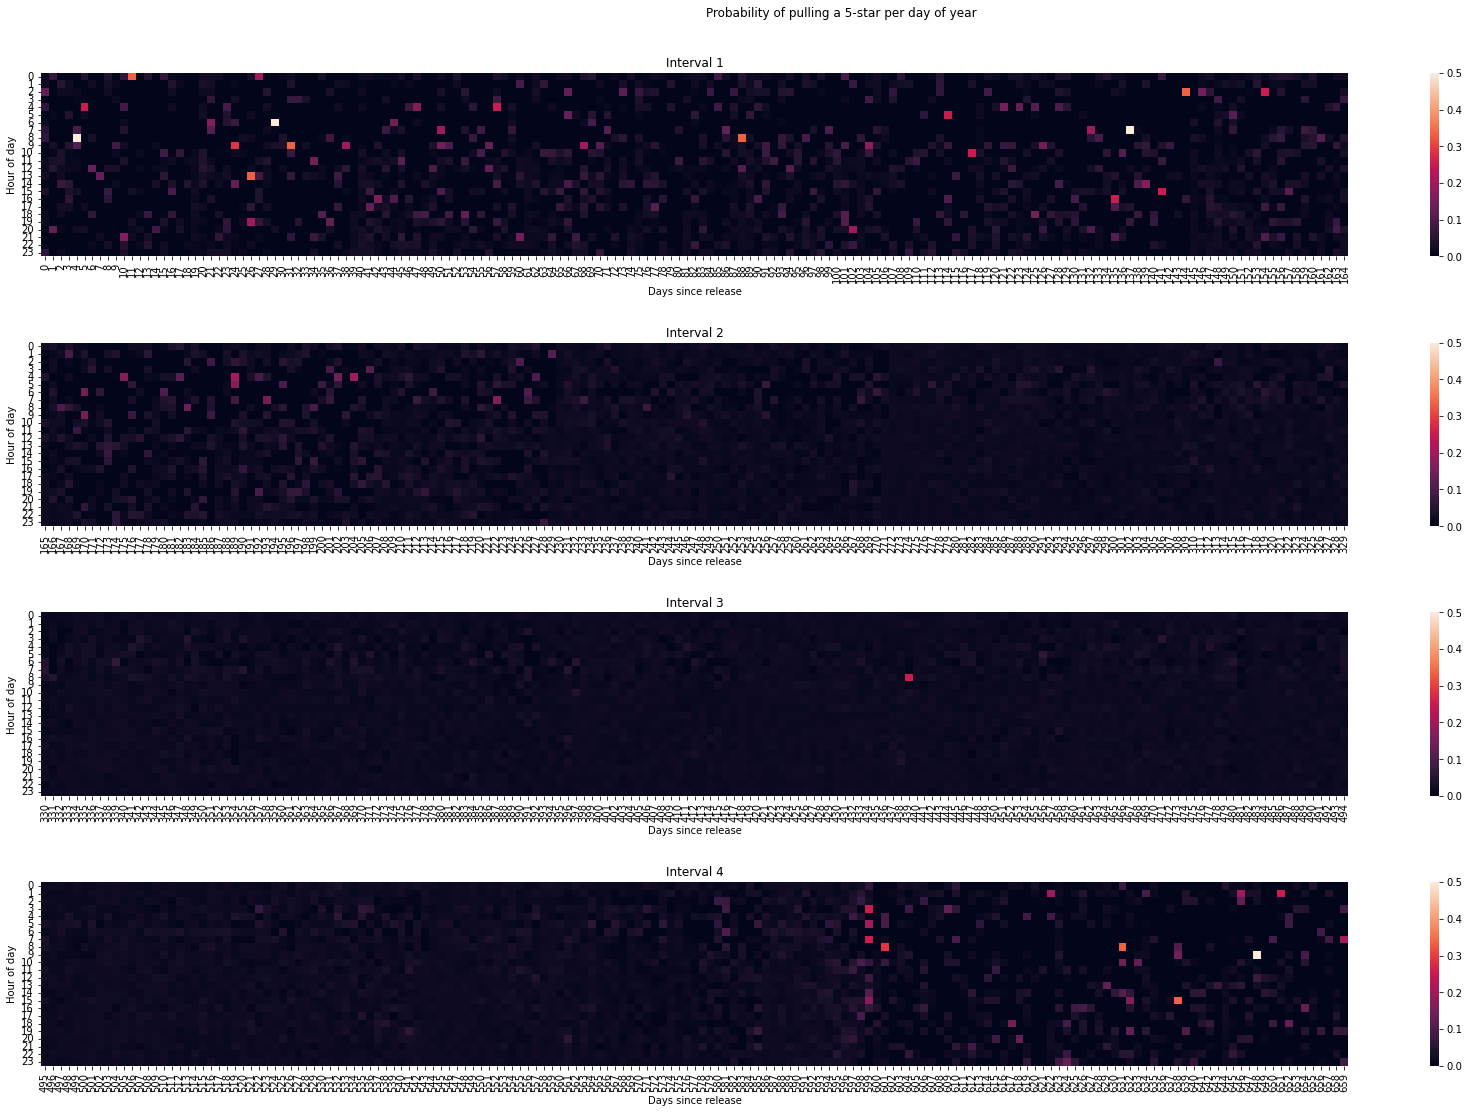

In [48]:
fig, ax = plt.subplots(DSR_ROWS, figsize=DSR_FIGSIZE)
dsr_heatmap(all_fives, ax, "Prob(5-star)", interval_name="Interval")
fig.suptitle("Probability of pulling a 5-star per day of year")
fig.tight_layout(pad=DSR_PAD)

### 4-star


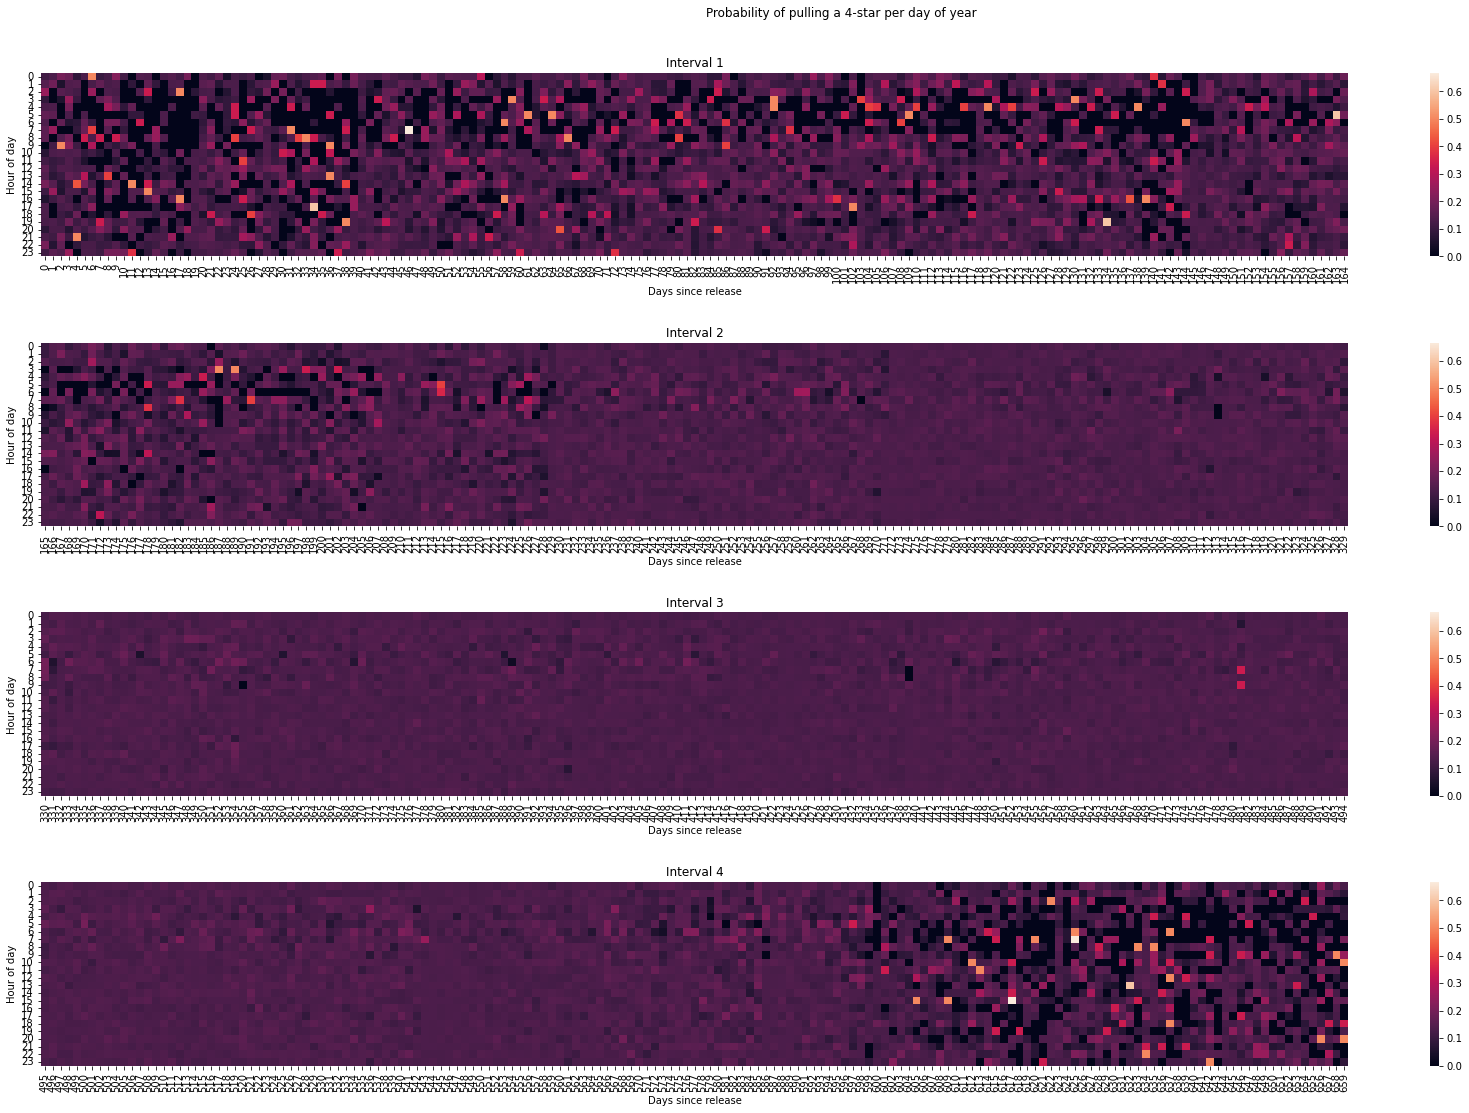

In [49]:
fig, ax = plt.subplots(DSR_ROWS, figsize=DSR_FIGSIZE)
dsr_heatmap(all_fours, ax, "Prob(4-star)", interval_name="Interval")
fig.suptitle("Probability of pulling a 4-star per day of year")
fig.tight_layout(pad=DSR_PAD)


## Observations

### Number of Pulls

Other than some outliers, assumed to be the days where new banners come out, the number of pulls at different hours
of each day seem to be pretty uniform.

### Getting 5/4-star

Somehow, at least for the first year or so after the game's launch, there seems to be a pattern where
if a player pulls gacha some time between 2-10am, they are more likely to pull either a 4 or 5 star item.


In [50]:
print(
    f"Mean of Prob(4- or 5-star) 2-10am: \t{np.mean(all_fives[:11, :]) * 100}%")
print(
    f"Mean of Prob(4- or 5-star) not 2-10am: \t{np.mean(all_fives[11:, :]) * 100}%")
print(f"Mean of Prob(4- or 5-star) all day: \t{np.mean(all_fives) * 100}%")


Mean of Prob(4- or 5-star) 2-10am: 	1.5044655788660257%
Mean of Prob(4- or 5-star) not 2-10am: 	1.4954743286995615%
Mean of Prob(4- or 5-star) all day: 	1.499595318359191%


Although not very significant, we can see that there is a _very small_ difference when it comes to
the mean of probability of getting a 5-star.


# Second Try: _Separated by Banner_ and _Ignored Outliers_

One of the patterns seen is that the probability seems to become more and more uniform as time goes on.
Thus, we are going to ignore the _"combined"_ grouping, meaning that we will ignore the day-of-X groupings
in the following attempt(s).

Additionally, since Genshin Impact comes out with new banners every now and then which would impact the
maximum and minimum value of the number of pulls per day, making the mean and visualization confusing.

Note that we will only look at 5-star drops over time since release only just to save a bit of space and time.


In [51]:
NEW_DSR_FIGSIZE = (25, 14)
DSR_ROWS = 3

# NEW_START_DATE = date(2020, 12, 4)
NEW_START_DATE = data_set02["DateTime"]\
    .apply(simplify_dt)\
    .unique()\
    .min()[0]
# NEW_START_DATE = None


In [52]:
after_newstart = full_df.DateTime.apply(lambda dt: dt[0] > NEW_START_DATE)
newstart_df = full_df[after_newstart].sort_values("DateTime") if NEW_START_DATE is not None else full_df

print(newstart_df.shape)
newstart_df.sample(5)


(9572049, 3)


,Rarity,DateTime,Banner
667820,4,"(2022-05-12, 18)",302
9582824,3,"(2022-01-25, 19)",301
384942,3,"(2022-01-25, 21)",301
1282248,3,"(2022-03-01, 17)",301
9341918,3,"(2022-03-12, 21)",302


In [53]:
def transform_ignore_outliers(full_banner: np.ndarray, percentile=99):
    q_val = np.percentile(full_banner, percentile)
    m_val = np.mean(full_banner)

    outliers = full_banner > q_val
    copy = full_banner.copy()
    copy[outliers] = m_val

    return copy


In [54]:
unique_dates = newstart_df["DateTime"].apply(lambda dt: dt[0]).unique()

if NEW_START_DATE is None:
    days_since_2021 = DAYS_SINCE_RELEASE
else:
    days_since_2021 = (np.max(unique_dates) - NEW_START_DATE).days + 1
    def dsr_transformer(dt): return ((dt[0] - NEW_START_DATE).days, dt[1])


## Permanent Banner


In [55]:
full_perm = newstart_df[newstart_df.Banner == 200]
perm_transform = transform_func(
    full_perm, dsr_transformer, (24, days_since_2021))
perm_all, perm_5stars, _ = perm_transform
perm_all = transform_ignore_outliers(perm_all)


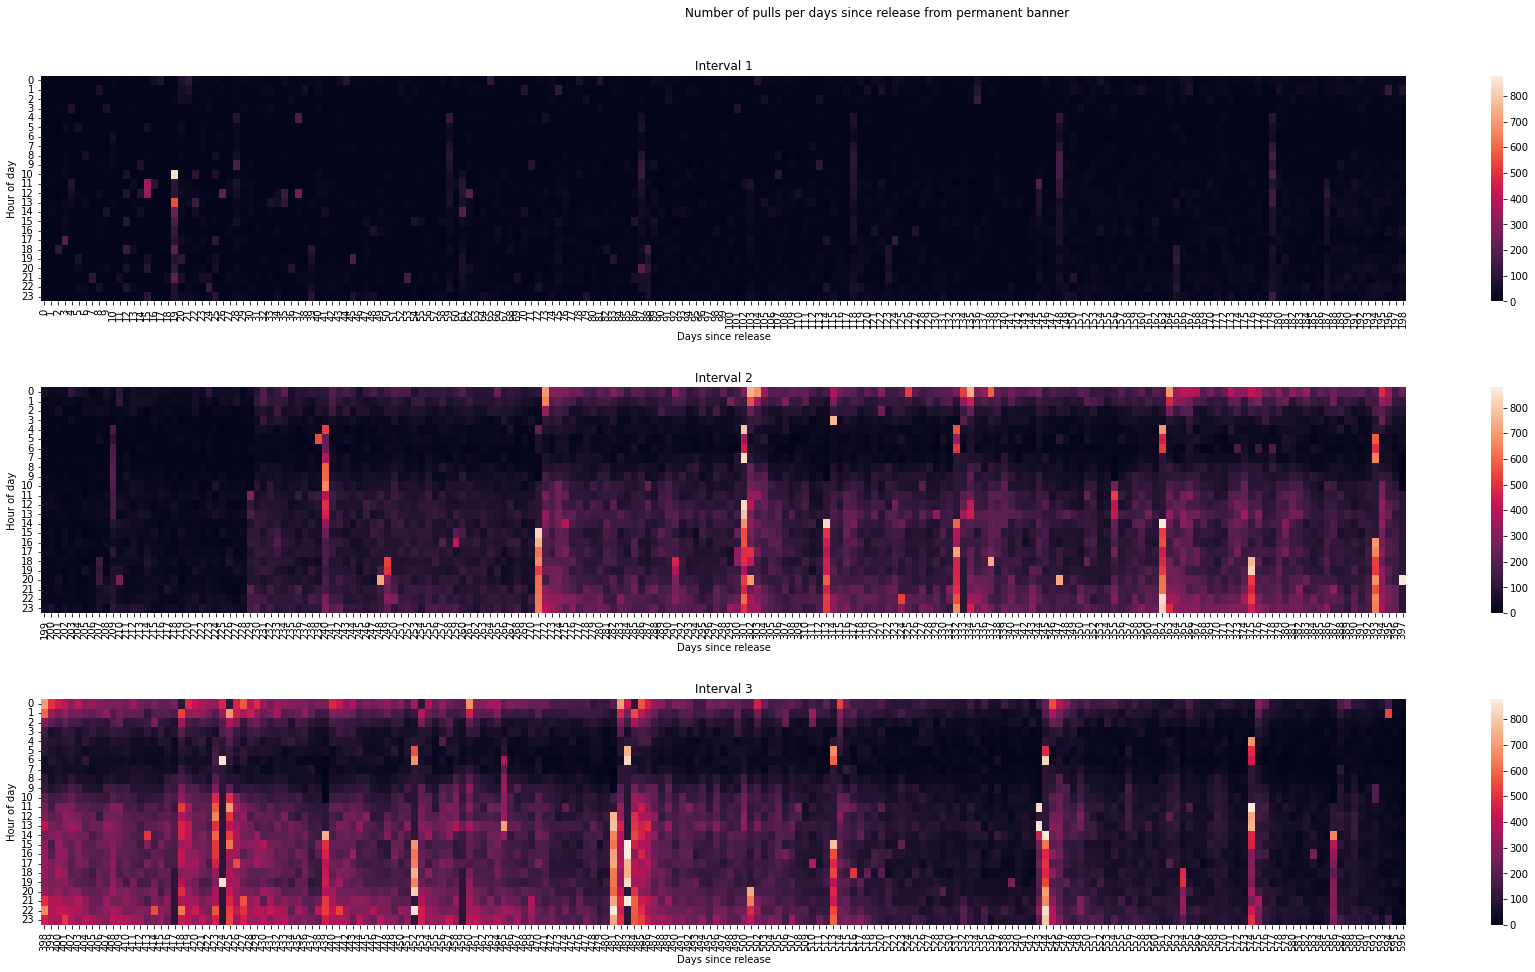

In [56]:
fig, ax = plt.subplots(DSR_ROWS, figsize=NEW_DSR_FIGSIZE)
dsr_heatmap(perm_all, ax, "Number of pulls", interval_name="Interval")
fig.suptitle("Number of pulls per days since release from permanent banner")
fig.tight_layout(pad=DSR_PAD)


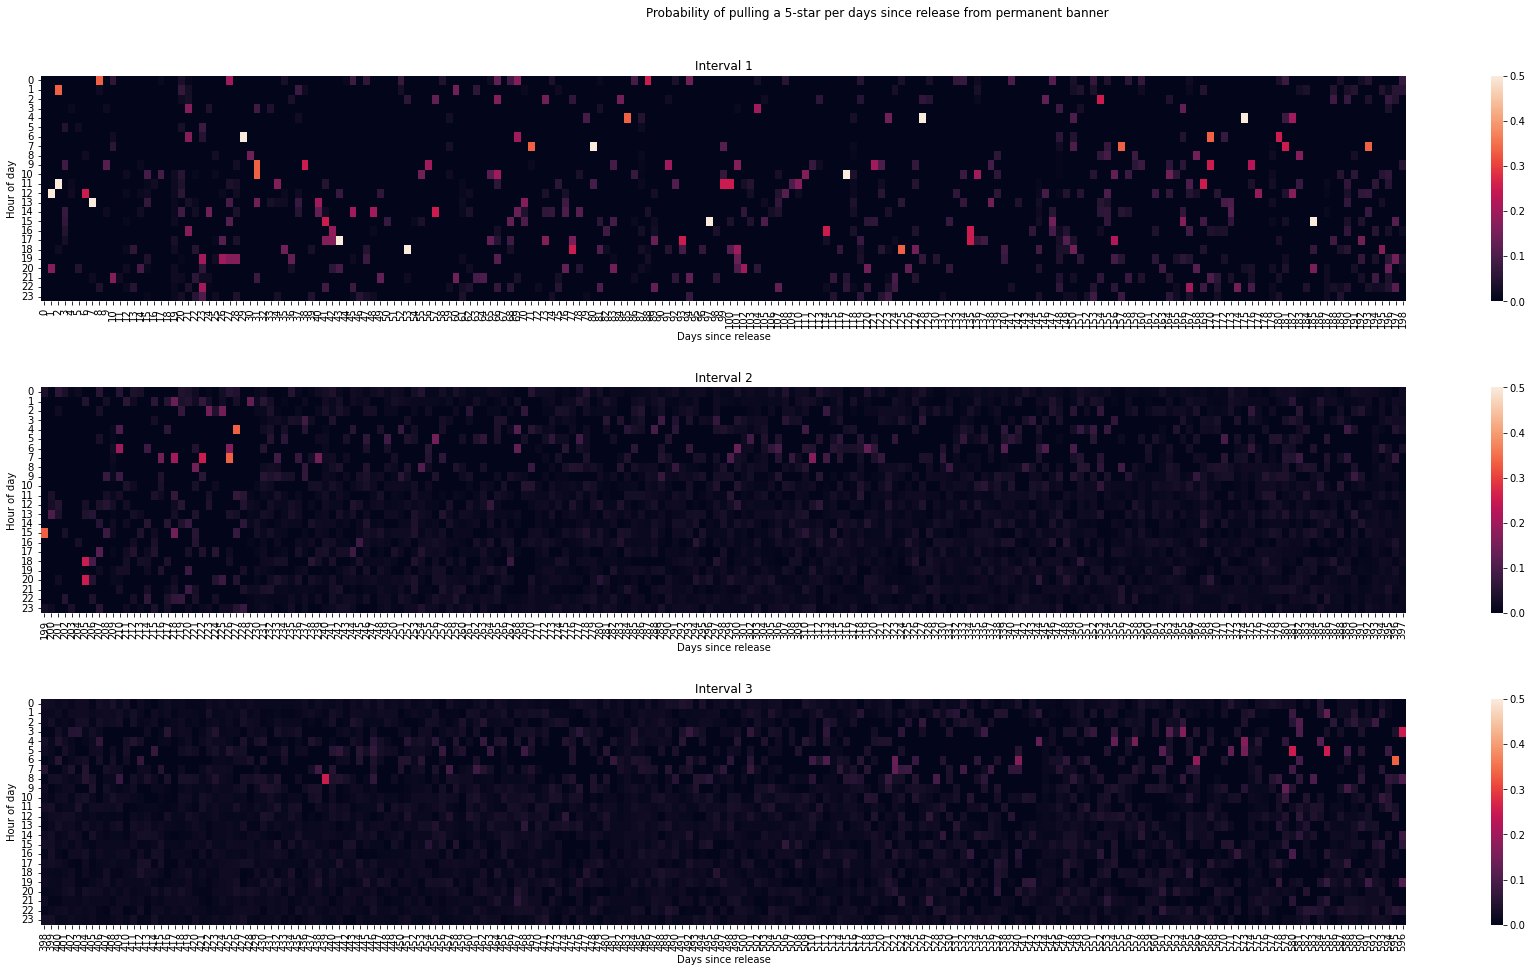

In [57]:
fig, ax = plt.subplots(DSR_ROWS, figsize=NEW_DSR_FIGSIZE)
dsr_heatmap(perm_5stars, ax, "Prob(5-star)", interval_name="Interval")
fig.suptitle("Probability of pulling a 5-star per days since release from permanent banner")
fig.tight_layout(pad=DSR_PAD)


## Limited Character Banner


In [58]:
full_char = pd.concat([newstart_df[newstart_df.Banner == 301],
                      newstart_df[newstart_df.Banner == 400]])
char_all, char_5stars, _ = transform_func(
    full_char, dsr_transformer, (24, days_since_2021))
char_all = transform_ignore_outliers(char_all)


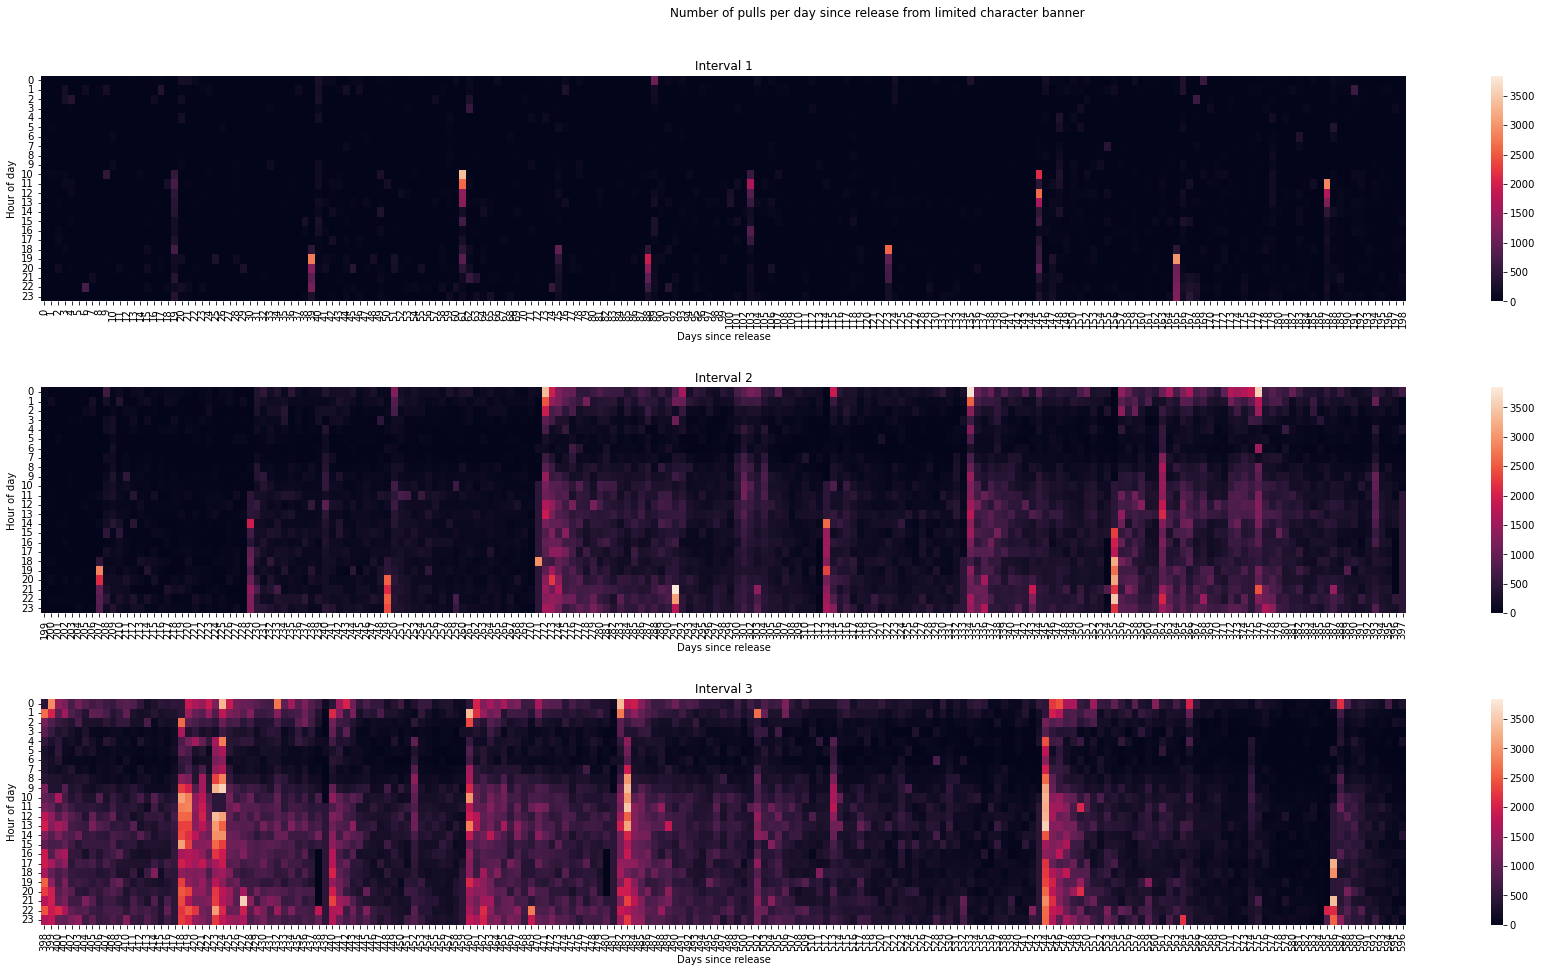

In [59]:
fig, ax = plt.subplots(DSR_ROWS, figsize=NEW_DSR_FIGSIZE)
dsr_heatmap(char_all, ax, "Number of pulls", interval_name="Interval")
fig.suptitle("Number of pulls per day since release from limited character banner")
fig.tight_layout(pad=DSR_PAD)


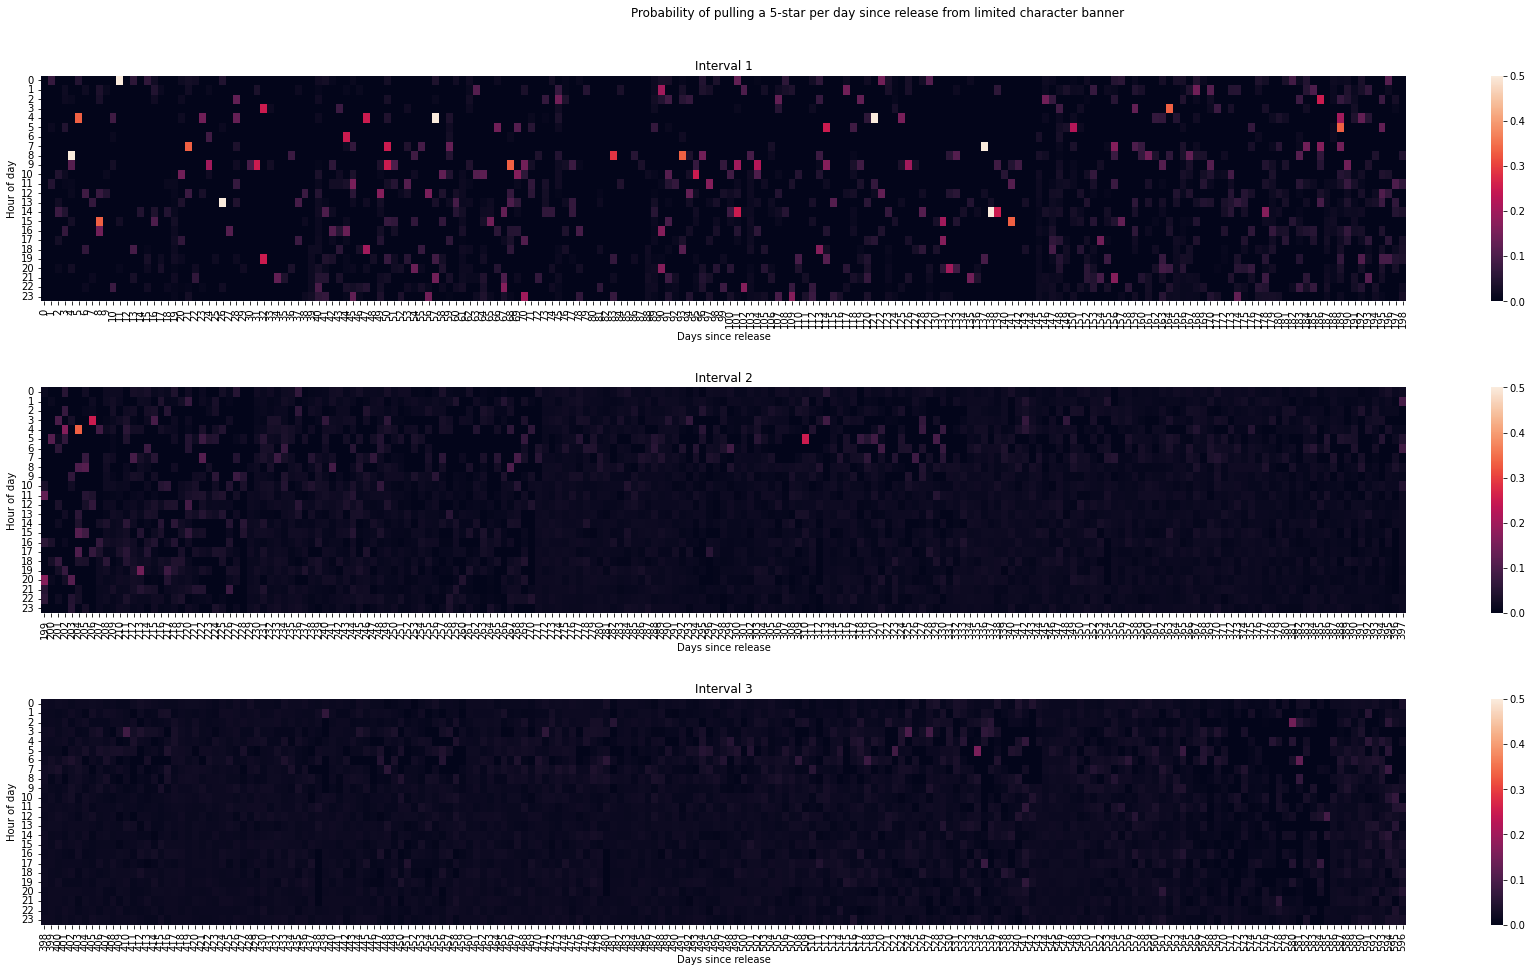

In [60]:
fig, ax = plt.subplots(DSR_ROWS, figsize=NEW_DSR_FIGSIZE)
dsr_heatmap(char_5stars, ax, "Prob(5-star)", interval_name="Interval")
fig.suptitle("Probability of pulling a 5-star per day since release from limited character banner")
fig.tight_layout(pad=DSR_PAD)


## Limited Weapon Banner


In [61]:
full_weapon = newstart_df[newstart_df.Banner == 302]
weapon_all, weapon_5stars, _ = transform_func(
    full_weapon, dsr_transformer, (24, days_since_2021))
weapon_all = transform_ignore_outliers(weapon_all)


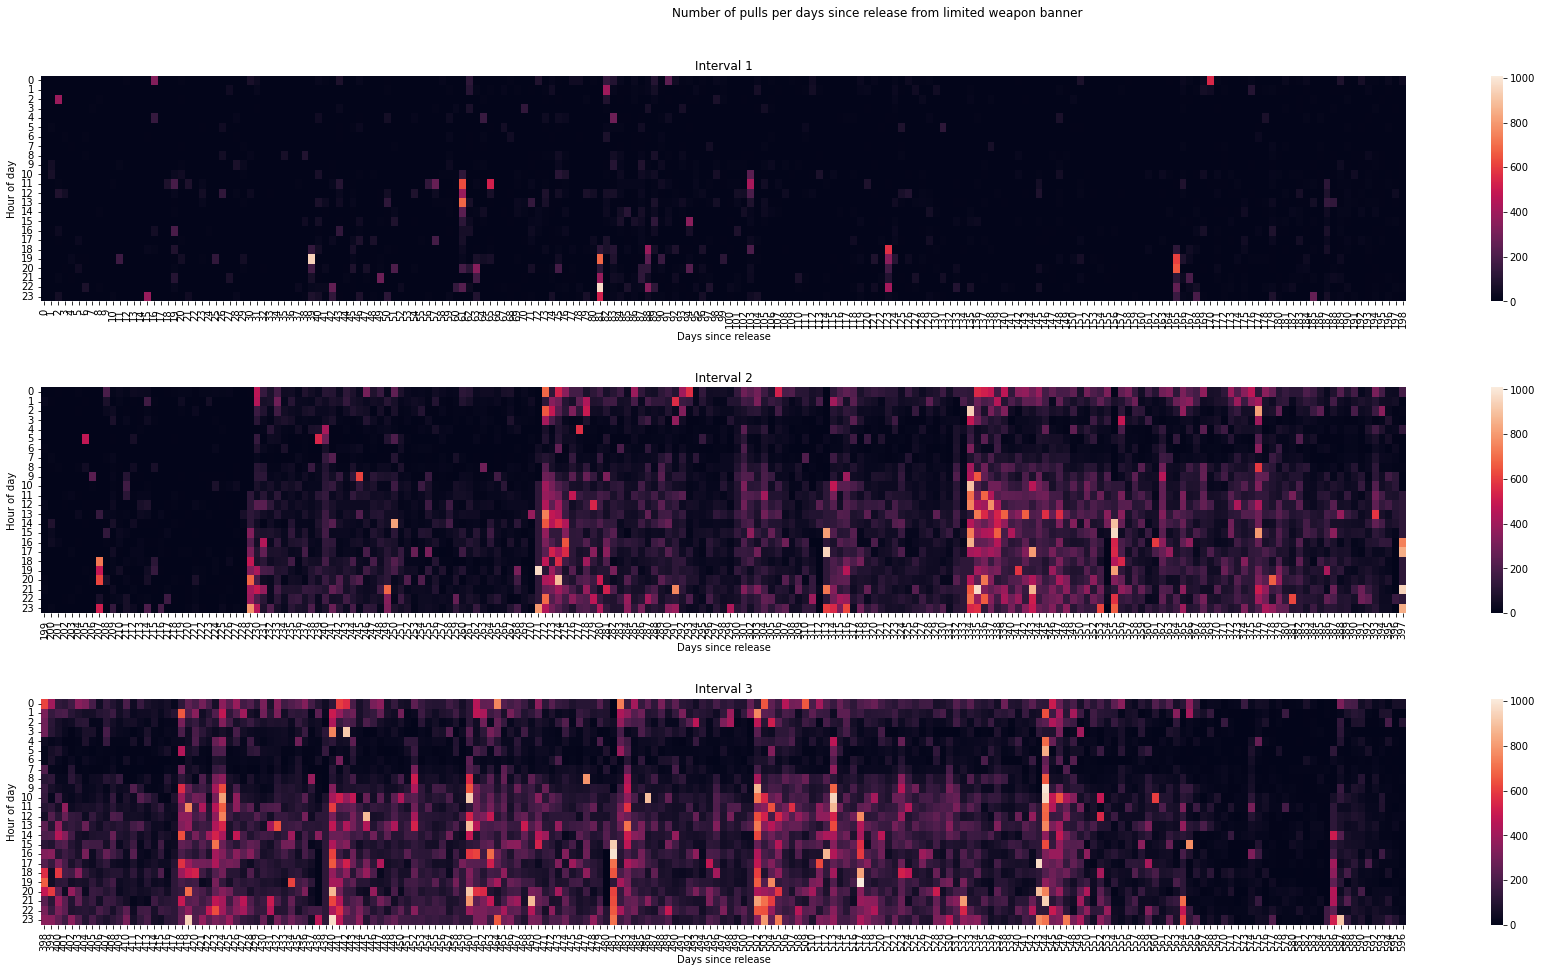

In [62]:
fig, ax = plt.subplots(DSR_ROWS, figsize=NEW_DSR_FIGSIZE)
dsr_heatmap(weapon_all, ax, "Number of pulls", interval_name="Interval")
fig.suptitle("Number of pulls per days since release from limited weapon banner")
fig.tight_layout(pad=DSR_PAD)


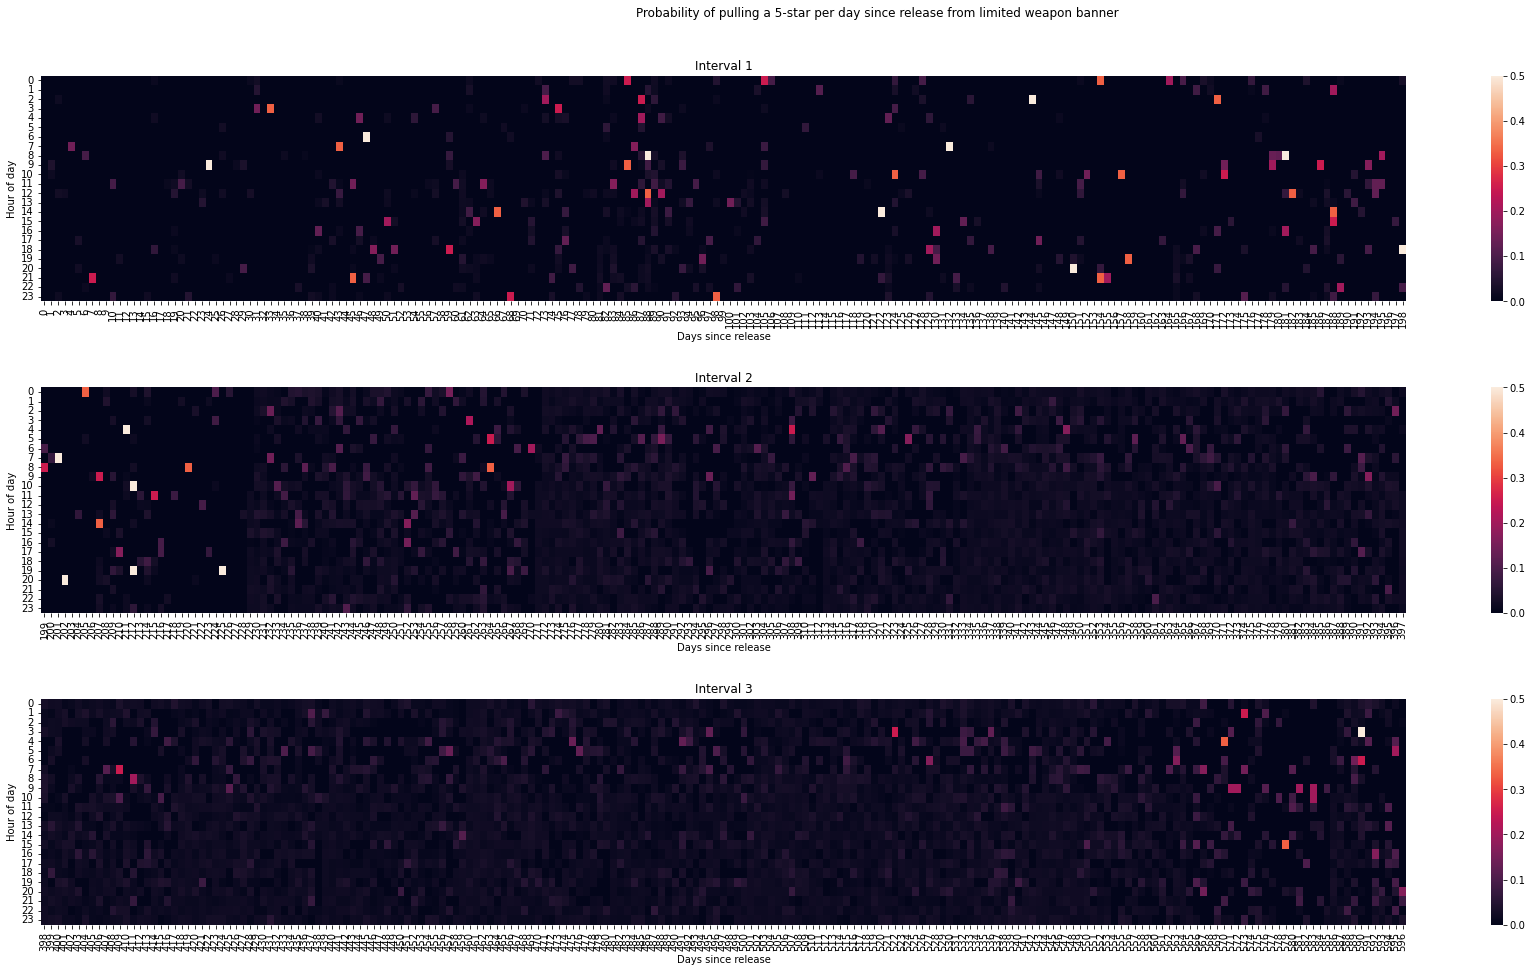

In [63]:
fig, ax = plt.subplots(DSR_ROWS, figsize=NEW_DSR_FIGSIZE)
dsr_heatmap(weapon_5stars, ax, "Prob(5-star)", interval_name="Interval")
fig.suptitle("Probability of pulling a 5-star per day since release from limited weapon banner")
fig.tight_layout(pad=DSR_PAD)


# Last Try: _Seems like it's just the time of day now_

So far, we've had a suspicion that there might be a higher likelihood of pulling a 5-star in the earlier
hours of the morning. However, we don't really know which interval is best. Thus, we're going to just
average the probability of


In [64]:
full_dsr = transform_func(full_df, dsr_transformer, (24, DAYS_SINCE_RELEASE))
_, pr_5stars, _ = full_dsr


Text(0, 0.5, 'Prob(5-star)')

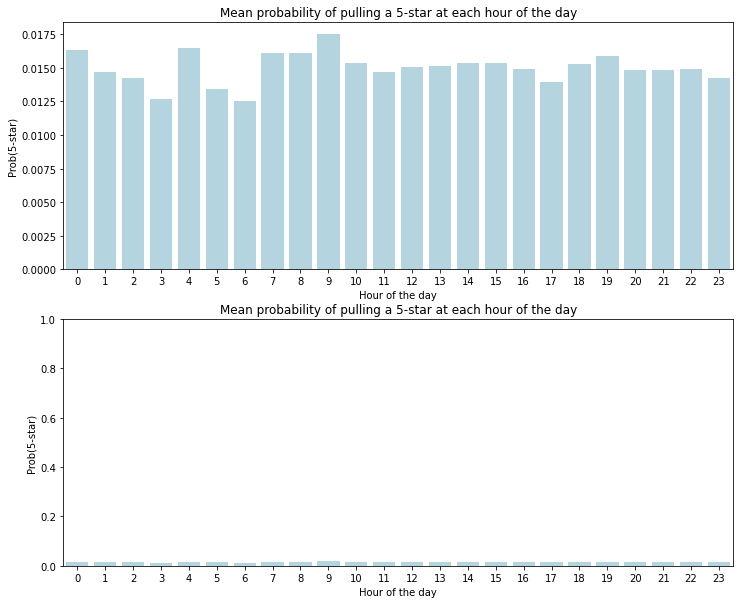

In [65]:
summed_full_dsr = np.mean(pr_5stars, axis=1).T

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 10))

sns.barplot(x=np.arange(0, 24), y=summed_full_dsr, ax=ax1, color="lightblue")
ax1.set_title("Mean probability of pulling a 5-star at each hour of the day")
ax1.set_xlabel("Hour of the day")
ax1.set_ylabel("Prob(5-star)")

sns.barplot(x=np.arange(0, 24), y=summed_full_dsr, ax=ax2, color="lightblue")
ax2.set_ylim(0, 1)
ax2.set_title("Mean probability of pulling a 5-star at each hour of the day")
ax2.set_xlabel("Hour of the day")
ax2.set_ylabel("Prob(5-star)")
